## Exploratory Data Analysis

Working on: https://www.kaggle.com/c/understanding_cloud_organization/

In [1]:
import os
import math
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
DATA = 'data'
train = pd.read_csv("data/train.csv")

In [3]:
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
train.shape

(22184, 2)

In [39]:
train_path = f'{DATA}/train_images/'
mask_path = f'{DATA}/train_images_annots/'
test_path = f'{DATA}/test_images/'
n_train = len(os.listdir(train_path))
n_test = len(os.listdir(test_path))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5547 images in train dataset
There are 3698 images in test dataset


Let's take a look at how many instances of each class we have:

In [6]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

So our class balance ranges from ~19% for Flower to ~31% for Sugar. 

Let's take a look at how many classes are present in each image:

In [7]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

Let's separate out the filename and the label for each image.

In [8]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train.head()

,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


In [9]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

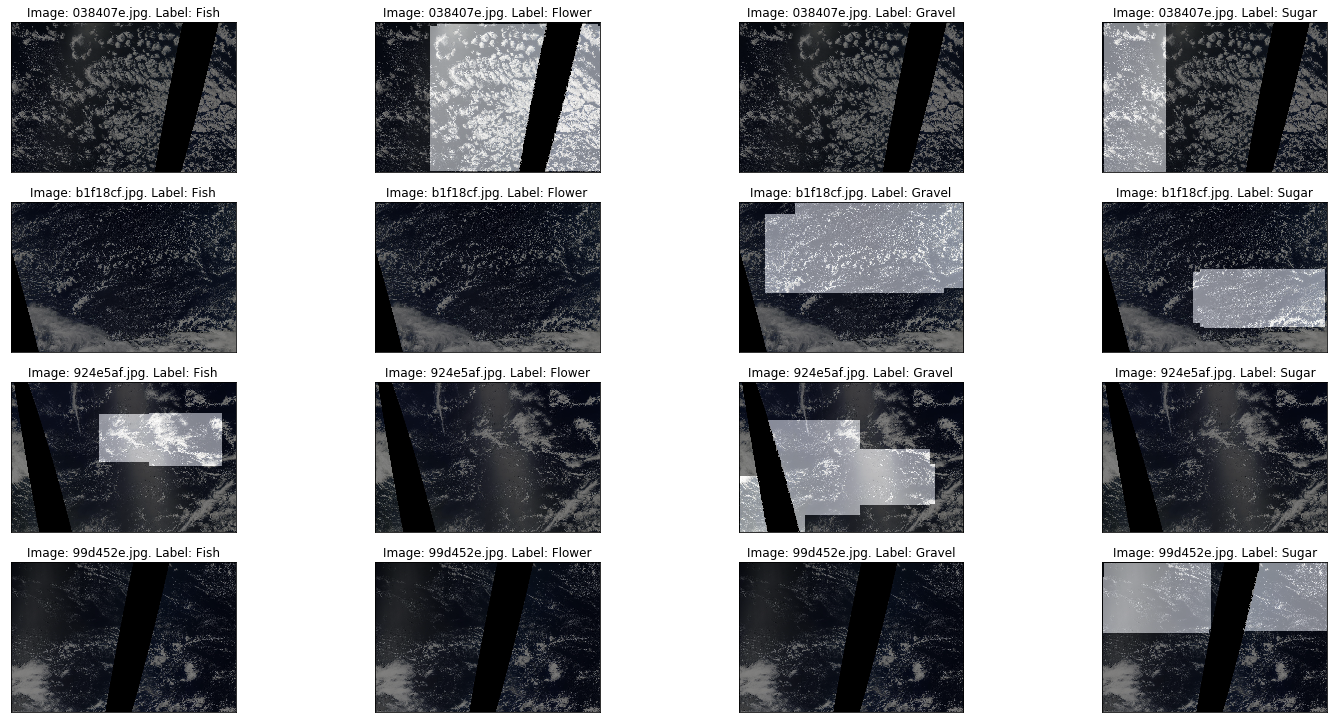

In [10]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{DATA}/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        if isinstance(mask_rle, str):
            mask = rle_decode(mask_rle)
        else:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

In [11]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)

## Convert Run Length Encoding to Image Masks

In [30]:
train.head()

,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


FastAI wants complete image masks for training so let's create them.

In [31]:
def createChannelFromMask(encoded_pixels, shape, value=0):
    newChannel = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    s = encoded_pixels.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        newChannel[lo:hi] = 1
        
    newChannel = newChannel.reshape(shape, order='F')
    return newChannel

In [18]:
from PIL import Image
x = 0
for row in train.iloc[::4, :].iterrows():
#for row in train[train['im_id'] == '446a3d6.jpg'].iterrows():
    x = x + 1
    
    index = row[0]
    fish = train.iloc[index]
    flower = train.iloc[index + 1]
    gravel = train.iloc[index + 2]
    sugar = train.iloc[index + 3]
    
    shape = (1400, 2100)
    
    fullPath = "data/train_images/" + fish['im_id']
    im = Image.open(fullPath) # Can be many different formats.
    
    fishChannel = np.zeros(shape, dtype=np.uint8)
    flowerChannel = np.zeros(shape, dtype=np.uint8)
    gravelChannel = np.zeros(shape, dtype=np.uint8)
    sugarChannel = np.zeros(shape, dtype=np.uint8)
    
    if isinstance(fish['EncodedPixels'], str):
        fishChannel = createChannelFromMask(fish['EncodedPixels'], shape)
    
    if isinstance(flower['EncodedPixels'], str):
        flowerChannel = createChannelFromMask(flower['EncodedPixels'], shape)
    
    if isinstance(gravel['EncodedPixels'], str):
        gravelChannel = createChannelFromMask(gravel['EncodedPixels'], shape)
    
    if isinstance(sugar['EncodedPixels'], str):
        sugarChannel = createChannelFromMask(sugar['EncodedPixels'], shape, 1)
   
    #Save image
    newImage = np.stack([fishChannel, flowerChannel, gravelChannel, sugarChannel], axis=-1)
    
    if not os.path.exists("data/train_images_annots"):
        os.mkdir("data/train_images_annots")
        
    im = Image.fromarray(newImage, mode='RGBA')
    im.save("data/train_images_annots/" + fish['im_id'].replace('.jpg', '.png'))

## Resize Images and Masks

During training, we appear to be bottlenecked by loading the full-size `1400x2100` images and resizing them so they're small enough to fit on the GPU.

To avoid doing this repeatedly during training, let's create multiple smaller sized datasets.


In [27]:
original_size = (1400, 2100)
new_size = (350, 525)

In [111]:
def resizeImagesInDirectory(oldPath, newPath, newSize, fileType="JPEG"):
    
    old_images = os.listdir(oldPath)

    #Make sure the folder exists
    if not os.path.exists(newPath):
        os.mkdir(newPath)
    
    #Go through directory, resize and save in newPath
    for image in old_images:
        fullPath = oldPath + image
        newFullPath = newPath + image
        
        #If the file already exists, don't waste time opening/resizing/saving it
        if os.path.exists(newFullPath):
            continue

        img = Image.open(fullPath)
        
        if fileType == "JPEG":
            img.thumbnail(newSize, Image.ANTIALIAS)
            img.save(newFullPath, fileType)
        else:
            # We don't seem to be able to use thumbnail to rescale our custom RGBA masks
            # I think that it may be removing the RGB portions of the image whenever
            # opacity is 0 (ie. for almost everything)
            a = np.asarray(img)
            if a.ndim== 2: 
                a = np.expand_dims(a,2)
            a = np.transpose(a, (1, 0, 2))
            a = np.transpose(a, (2, 1, 0))
            
            # large image is shape (4, 1400, 2100)
            # small image is shape (4, 350, 525)
            input_size = np.array((1400,2100))
            output_size = np.array((350,525))
            bin_size = input_size // output_size
            
            newImage = a.reshape((4, output_size[0], bin_size[0], output_size[1], bin_size[1])).max(4).max(2)
            newImage = np.transpose(newImage, (1,2,0))
            
            #Convert back to image and save
            im = Image.fromarray(newImage, mode='RGBA')
            im.save(newFullPath)            

In [106]:
train_masks = os.listdir(mask_path)
test_images = os.listdir(test_path)

new_train_path = f'{DATA}/train_images_{new_size[0]}x{new_size[1]}/'
new_mask_path = f'{DATA}/train_images_annots_{new_size[0]}x{new_size[1]}/'
new_test_path = f'{DATA}/test_images_{new_size[0]}x{new_size[1]}/'

In [107]:
new_mask_path

'data/train_images_annots_350x525/'

In [108]:
resizeImagesInDirectory(train_path, new_train_path, new_size)

In [109]:
resizeImagesInDirectory(test_path, new_test_path, new_size)

In [112]:
resizeImagesInDirectory(mask_path, new_mask_path, new_size, "PNG")